In [1]:
# 在Colab中运行此代码
!pip install gym numpy matplotlib

import gym
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def discretize_state(state, bins):
    """将状态离散化"""
    state_index = []
    for i in range(len(state)):
        state_index.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(state_index)

def create_bins():
    bins = [
        np.linspace(-4.8, 4.8, 10),     # Cart Position
        np.linspace(-4, 4, 10),         # Cart Velocity
        np.linspace(-0.418, 0.418, 10), # Pole Angle
        np.linspace(-4, 4, 10)          # Pole Velocity
    ]
    return bins

def select_action(Q, state, epsilon):
    """选择动作"""
    if np.random.rand() < epsilon:
        return np.random.choice([0, 1])
    else:
        return np.argmax(Q[state])


In [3]:
def sarsa(env, bins, episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1):
    Q = np.zeros((10, 10, 10, 10, env.action_space.n))
    for episode in range(episodes):
        state = discretize_state(env.reset(), bins)
        action = select_action(Q, state, epsilon)
        done = False
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_state = discretize_state(next_state, bins)
            next_action = select_action(Q, next_state, epsilon)
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            state = next_state
            action = next_action
    return Q


In [4]:
def q_learning(env, bins, episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1):
    Q = np.zeros((10, 10, 10, 10, env.action_space.n))
    for episode in range(episodes):
        state = discretize_state(env.reset(), bins)
        done = False
        while not done:
            action = select_action(Q, state, epsilon)
            next_state, reward, done, _ = env.step(action)
            next_state = discretize_state(next_state, bins)
            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])
            state = next_state
    return Q


In [5]:
def double_q_learning(env, bins, episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1):
    Q1 = np.zeros((10, 10, 10, 10, env.action_space.n))
    Q2 = np.zeros((10, 10, 10, 10, env.action_space.n))
    for episode in range(episodes):
        state = discretize_state(env.reset(), bins)
        done = False
        while not done:
            action = select_action(Q1 + Q2, state, epsilon)
            next_state, reward, done, _ = env.step(action)
            next_state = discretize_state(next_state, bins)
            if np.random.rand() < 0.5:
                Q1[state][action] += alpha * (reward + gamma * Q2[next_state][np.argmax(Q1[next_state])] - Q1[state][action])
            else:
                Q2[state][action] += alpha * (reward + gamma * Q1[next_state][np.argmax(Q2[next_state])] - Q2[state][action])
            state = next_state
    return Q1 + Q2


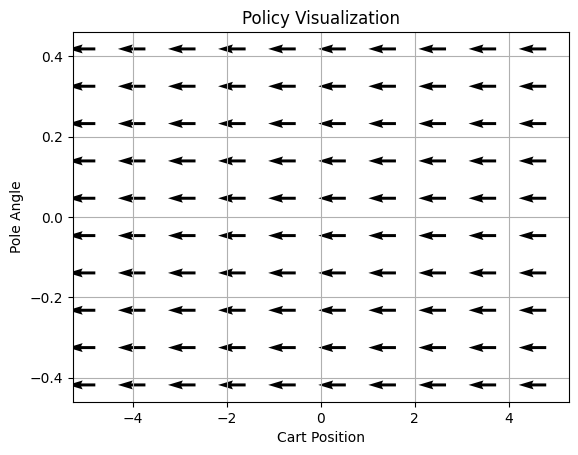

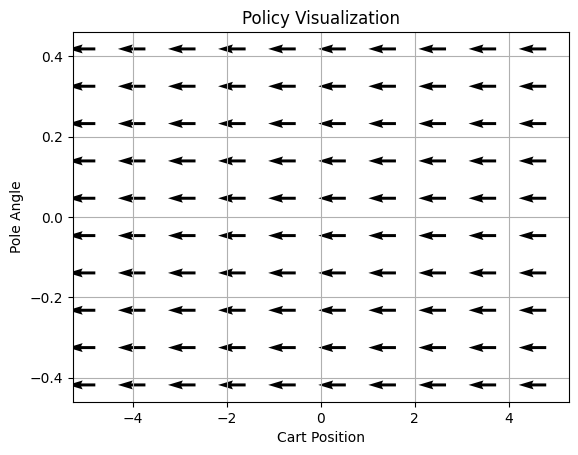

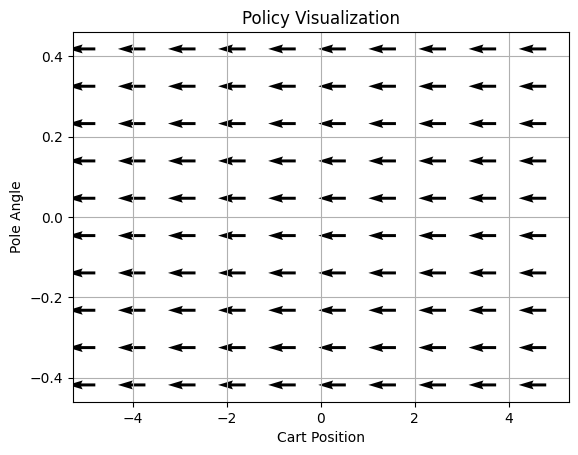

In [7]:
env = gym.make('CartPole-v1')
bins = create_bins()

# 运行SARSA算法
Q_sarsa = sarsa(env, bins)

# 运行Q-学习算法
Q_q_learning = q_learning(env, bins)

# 运行双重Q-学习算法
Q_double_q_learning = double_q_learning(env, bins)

# 可视化结果
def visualize_policy(Q, bins):
    x = np.linspace(-4.8, 4.8, 10)
    theta = np.linspace(-0.418, 0.418, 10)
    X, Theta = np.meshgrid(x, theta)
    U = np.zeros_like(X)
    V = np.zeros_like(Theta)

    for i in range(len(x)):
        for j in range(len(theta)):
            state = [x[i], 0, theta[j], 0]
            discretized_state = discretize_state(state, bins)
            state_idx = np.ravel_multi_index(discretized_state, (10, 10, 10, 10))
            action = np.argmax(Q[discretized_state])
            if action == 0:
                U[j, i] = -1
            else:
                U[j, i] = 1
            V[j, i] = 0

    plt.quiver(X, Theta, U, V)
    plt.xlabel('Cart Position')
    plt.ylabel('Pole Angle')
    plt.title('Policy Visualization')
    plt.grid()
    plt.show()

visualize_policy(Q_sarsa, bins)
visualize_policy(Q_q_learning, bins)
visualize_policy(Q_double_q_learning, bins)
